In [1]:
# Dependencies


import numpy as np
import networkx as nx
from sklearn.base import BaseEstimator, ClassifierMixin
from datasets import load_dataset
from sklearn.model_selection import cross_val_score, ShuffleSplit
from graph import process_dataset, transform, centrality
from IPython.display import clear_output
import sklearn
from sklearn.metrics import accuracy_score
from functools import partial
import time

import gc

import sys

sys.path.append("../")

from hdc import hdv, bind, bundle, sbundle, ItemMemory, hdvw, hdva, cosim, hdvsc, zero

In [2]:
# encode_graphe -> graphHD (graph, vertices, dimensions)


def encode_graphe(graph, vertices, dimensions):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)

    # Es = zero(dimensions)
    Es = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        # Es = bundle([Es, bind([vertices[edge[0]], vertices[edge[1]]])])
        Es.append(bind([v1, v2]))

    return bundle(Es)

In [3]:
# encode_graphew -> vertices with hdw and edges (graph, vertices, base)


def encode_graphew(graph, vertices, base):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))

    Es = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        Es.append(bind([v1, v2]))

    return bundle(Es)

In [4]:
# encode_graphv -> vertices with hdv and no edges (graph, vertices, base)


def encode_graphv(graph, vertices, dimensions):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)
        Vs.append(vertices[node])

    return bundle(Vs)

In [5]:
# encode_graphvw -> vertices with hdw and no edges (graph, vertices, base)


def encode_graphvw(graph, vertices, base):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))
        Vs.append(vertices[node])

    return bundle(Vs)

In [6]:
# encode_graphvc -> vertices with hdvc and no edges (graph, vertices, vs)


def encode_graphvc(graph, vertices, vs):  # [0-1] encoded into hvds with precision n
    return bundle(map(lambda n: vs[round(float(n) * len(vs))], graph.nodes))

In [7]:
# def encode_graphrw(graph, vertices, pm): # random walk

In [8]:
class GraphClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, encoder, transformer, step=20):
        self.encoder = encoder
        self.transformer = transformer
        self.step = step
        self.memory = ItemMemory()
        self.vertices = dict()

    def fit(self, X, y):
        classes = {label: [] for label in set(y)}

        for i, graph in enumerate(self.transformer(X)):
            classes[y[i]].append(self.encoder(graph, self.vertices))

        for key, value in classes.items():
            for i in range(0, len(value), self.step):
                H = bundle(value[i : i + self.step])
                self.memory.add_vector(str(key), H)

        return self

    def predict(self, X):
        p = []
        for query in self.transformer(X):
            # query_vector = self.encoder(query, self.vertices)
            (label, _, _) = self.memory.cleanup(self.encoder(query, self.vertices))
            p.append(int(label))

        return p

In [9]:
# DATASET = load_dataset("graphs-datasets/MUTAG")["train"]
DATASET = load_dataset("graphs-datasets/PROTEINS")["train"]
# DATASET = load_dataset("graphs-datasets/AIDS")["full"]
# DATASET = load_dataset("graphs-datasets/IMDB-BINARY")["train"]

In [10]:
(graphs, labels) = process_dataset(DATASET)

In [11]:
FOLDS, REPS = 10, 3
ALPHA, DIGITS, DIMENSIONS, STEP, N = 0.15, 4, 10000, 400, 1000
CV = FOLDS

In [12]:
vs = hdvsc(N, DIMENSIONS, side=80, iter=4)

In [13]:
import ctypes


encoders = {
    "graphe": partial(encode_graphe, dimensions=DIMENSIONS),
    "graphew": partial(encode_graphew, base=hdv(DIMENSIONS)),
    "graphv": partial(encode_graphv, dimensions=DIMENSIONS),
    "graphvw": partial(encode_graphvw, base=hdv(DIMENSIONS)),
    # "graphvc": partial(encode_graphvc, vs=vs),
}

transformers = {
    # "pagerank": partial(centrality, rank=partial(nx.pagerank, alpha=ALPHA)),
    # "degree_centrality": partial(centrality, rank=partial(nx.degree_centrality)),
    # "eigenvector_centrality_numpy": partial(
    #     centrality, rank=partial(nx.eigenvector_centrality_numpy)
    # ),
    # "katz_centrality_numpy": partial(
    #     centrality, rank=partial(nx.katz_centrality_numpy)
    # ),
    "betweenness_centrality": partial(
        centrality, rank=partial(nx.betweenness_centrality)
    ),
    # "current_flow_closeness_centrality": partial(
    #     centrality, rank=partial(nx.current_flow_closeness_centrality)
    # ),
    "closeness_centrality": partial(centrality, rank=partial(nx.closeness_centrality)),
    # "edge_current_flow_betweenness_centrality": partial(
    #     centrality, rank=partial(nx.edge_current_flow_betweenness_centrality)
    # ),
    # "laplacian_centrality": partial(centrality, rank=partial(nx.laplacian_centrality)),
}


def cross(clf, graphs, labels):
    CV = ShuffleSplit()
    return cross_val_score(clf, graphs, labels, cv=CV, n_jobs=-1)


def main():
    for tl, transformer in transformers.items():
        print(tl)
        esum = 0
        for el, encoder in encoders.items():
            clf = GraphClassifier(encoder, transformer, step=STEP)
            sum = 0
            start_time = time.time()
            for i in range(REPS):
                # CV = ShuffleSplit()  # random_state=0
                scores = cross(clf, graphs, labels)
                sum += scores.mean()
                esum += scores.mean()
                del scores
            end_time = time.time()
            del clf
            libc = ctypes.CDLL("libc.so.6")
            libc.malloc_trim(0)
            print(
                "  Acc => %.5f" % (sum / REPS),
                "T => %.5f" % ((end_time - start_time) / REPS),
                el,
                "GC",
                gc.collect(),
            )
        print(" Acc => %.5f" % (esum / (REPS * len(encoders))))


def predict():
    for label, encoder in encoders.items():
        clf = GraphClassifier(encoder, transformers["closeness_centrality"], step=STEP)
        clf.fit(graphs[:900], labels[:900])
        # clear_output(wait=True)
        print(accuracy_score(labels[900:], clf.predict(graphs[900:])), label)


main()
# predict()

betweenness_centrality


KeyboardInterrupt: 

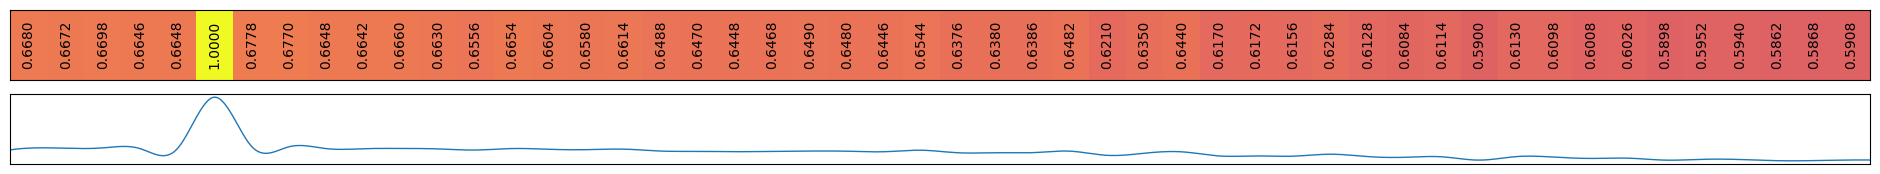

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage import gaussian_filter1d


def similarity_heatmap(xs, targets, round=2):
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)

    plt.figure(figsize=(24, 2))
    for n in range(len(targets)):
        plt.subplot(len(targets) * 2, 1, n + 2)
        sims = []

        for x in xs:
            sims.append(cosim(targets[n], x))

        xaxis = [x + 0.5 for x in range(len(xs))]
        X_Y_Spline = make_interp_spline(xaxis, sims)
        plt.xticks([]), plt.yticks([])
        plt.xlim(xmin=0, xmax=len(xs))
        X_ = np.linspace(0, len(xs), len(xs) * 16 * 2)
        Y_ = X_Y_Spline(X_)
        plt.plot(X_, Y_, linewidth=1)

        plt.subplot(len(targets) * 2, 1, n + 1)
        plt.yticks([]), plt.xticks([])
        plt.pcolormesh([sims] * 1, cmap="plasma", norm=norm)
        if round >= 0:
            for i in range(len(xs)):
                plt.text(
                    i + 0.5,
                    0 + 0.5,
                    f"%.{round}f" % sims[i],
                    ha="center",
                    va="center",
                    rotation="vertical",
                )
    plt.show()


similarity_heatmap(vs[:50], [vs[5]], round=4)